# Dense Retriever с multilingual-e5-base

Семантический поиск с использованием нейросетевых эмбеддингов.

In [1]:
!pip install pyarrow==18.1.0 -q
!pip install datasets==2.14.0 sentence-transformers sentencepiece faiss-cpu rank-bm25 torch tqdm -q
!pip install huggingface_hub -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 51.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.2 requires pyarrow>=21.0.0, but you have pyarrow 18.1.0 which is incompatible.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 8.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 93.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency res

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import gzip
import random
import requests
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
from huggingface_hub import hf_hub_download, list_repo_files
from sentence_transformers import SentenceTransformer
import faiss
import gc
import time

random.seed(42)
np.random.seed(42)

print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2026-01-22 09:21:20.238319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769073680.712413      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769073680.842649      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769073681.965672      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769073681.965725      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769073681.965728      55 computation_placer.cc:177] computation placer alr

CUDA: True
GPU: Tesla T4


## 1. Загрузка данных

In [3]:
BASE_URL = "https://huggingface.co/datasets/miracl/miracl/resolve/main/miracl-v1.0-ru/"

def load_queries(split: str) -> dict:
    url = f"{BASE_URL}topics/topics.miracl-v1.0-ru-{split}.tsv"
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        queries = {}
        for line in response.text.strip().split('\n')[1:]:
            parts = line.split('\t')
            if len(parts) >= 2:
                queries[parts[0]] = parts[1]
        return queries
    except:
        return {}

def load_qrels(split: str) -> dict:
    url = f"{BASE_URL}qrels/qrels.miracl-v1.0-ru-{split}.tsv"
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        qrels = defaultdict(lambda: {'positive': [], 'negative': []})
        for line in response.text.strip().split('\n'):
            parts = line.split('\t')
            if len(parts) >= 4:
                qid, doc_id, rel = parts[0], parts[2], int(parts[3])
                key = 'positive' if rel > 0 else 'negative'
                qrels[qid][key].append(doc_id)
        return dict(qrels)
    except:
        return {}

def get_required_doc_ids(qrels_dict: dict) -> set:
    doc_ids = set()
    for q in qrels_dict.values():
        doc_ids.update(q.get('positive', []))
        doc_ids.update(q.get('negative', []))
    return doc_ids

In [4]:
dev_queries = load_queries('dev')
dev_qrels = load_qrels('dev')
train_queries = load_queries('train')
train_qrels = load_qrels('train')

test_a_queries = load_queries('test-a')
test_b_queries = load_queries('test-b')
test_queries = {**test_a_queries, **test_b_queries}

all_qrels = {**dev_qrels, **train_qrels}
required_doc_ids = get_required_doc_ids(all_qrels)

print(f"Dev: {len(dev_queries)} запросов")
print(f"Train: {len(train_queries)} запросов")
print(f"Документов в qrels: {len(required_doc_ids)}")

Dev: 1251 запросов
Train: 4682 запросов
Документов в qrels: 41007


In [5]:
def load_corpus(target_docs: int = 500_000, seed: int = 42) -> tuple:
    random.seed(seed)
    
    all_files = list_repo_files("miracl/miracl-corpus", repo_type="dataset")
    jsonl_files = sorted([f for f in all_files if 'ru' in f and f.endswith('.jsonl.gz')])
    docs_per_file = target_docs // len(jsonl_files)

    corpus = {}
    doc_ids = []
    passages = []

    for jsonl_file in tqdm(jsonl_files, desc="Загрузка корпуса"):
        try:
            file_path = hf_hub_download(
                repo_id="miracl/miracl-corpus",
                filename=jsonl_file,
                repo_type="dataset"
            )

            file_docs = []
            required_docs = []

            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                for line in f:
                    if not line.strip():
                        continue
                    item = json.loads(line)
                    doc = {
                        'docid': item['docid'],
                        'title': item['title'],
                        'text': item['text'],
                        'full_text': f"{item['title']}. {item['text']}"
                    }
                    
                    if item['docid'] in required_doc_ids:
                        required_docs.append(doc)
                    else:
                        file_docs.append(doc)

            sample_size = min(docs_per_file, len(file_docs))
            selected = random.sample(file_docs, sample_size) if file_docs else []
            all_selected = selected + required_docs

            for doc in all_selected:
                if doc['docid'] not in corpus:
                    corpus[doc['docid']] = {
                        'title': doc['title'],
                        'text': doc['text'],
                        'full_text': doc['full_text']
                    }
                    doc_ids.append(doc['docid'])
                    passages.append(doc['full_text'])

        except Exception as e:
            print(f"Ошибка: {e}")
            continue

    return corpus, doc_ids, passages

corpus, doc_ids, passages = load_corpus(target_docs=500_000)
print(f"Загружено документов: {len(corpus):,}")

Загрузка корпуса:   0%|          | 0/20 [00:00<?, ?it/s]

miracl-corpus-v1.0-ru/docs-0.jsonl.gz:   0%|          | 0.00/100M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-1.jsonl.gz:   0%|          | 0.00/98.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-10.jsonl.gz:   0%|          | 0.00/75.7M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-11.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-12.jsonl.gz:   0%|          | 0.00/76.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-13.jsonl.gz:   0%|          | 0.00/78.2M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-14.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-15.jsonl.gz:   0%|          | 0.00/79.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-16.jsonl.gz:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-17.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-18.jsonl.gz:   0%|          | 0.00/81.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-19.jsonl.gz:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-2.jsonl.gz:   0%|          | 0.00/90.1M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-3.jsonl.gz:   0%|          | 0.00/89.4M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-4.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-5.jsonl.gz:   0%|          | 0.00/88.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-6.jsonl.gz:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-7.jsonl.gz:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-8.jsonl.gz:   0%|          | 0.00/74.5M [00:00<?, ?B/s]

miracl-corpus-v1.0-ru/docs-9.jsonl.gz:   0%|          | 0.00/73.5M [00:00<?, ?B/s]

Загружено документов: 541,007


## 2. Dense Retriever с E5

Модель E5 требует префиксы "query: " и "passage: " для запросов и документов.

In [6]:
MODEL_NAME = "intfloat/multilingual-e5-base"

class DenseRetrieverE5:
    def __init__(self, model_name: str = "intfloat/multilingual-e5-base"):
        print(f"Загрузка модели: {model_name}")
        
        self.model = SentenceTransformer(model_name)
        self.model_name = model_name
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        if self.device == 'cuda':
            self.model = self.model.to('cuda')
        
        self.index = None
        self.doc_ids = None
        self.passages = None
        self.dimension = None
    
    def _prepare_passage(self, text: str) -> str:
        return f"passage: {text}"
    
    def _prepare_query(self, text: str) -> str:
        return f"query: {text}"
    
    def fit(self, doc_ids: list, passages: list, batch_size: int = 128):
        print("Построение индекса...")
        
        self.doc_ids = doc_ids
        self.passages = passages
        n_docs = len(passages)
        
        # Размерность эмбеддингов
        with torch.no_grad():
            sample = self.model.encode(
                [self._prepare_passage(passages[0])],
                convert_to_numpy=True,
                normalize_embeddings=True
            )
        self.dimension = sample.shape[1]
        
        # FAISS индекс (Inner Product для косинусного сходства)
        self.index = faiss.IndexFlatIP(self.dimension)
        
        start_time = time.time()
        
        for start_idx in tqdm(range(0, n_docs, batch_size), desc="Индексация"):
            end_idx = min(start_idx + batch_size, n_docs)
            batch = passages[start_idx:end_idx]
            prepared_batch = [self._prepare_passage(p) for p in batch]
            
            with torch.no_grad():
                embeddings = self.model.encode(
                    prepared_batch,
                    batch_size=batch_size,
                    show_progress_bar=False,
                    convert_to_numpy=True,
                    normalize_embeddings=True
                )
            
            self.index.add(embeddings.astype('float32'))
            
            if (start_idx // batch_size) % 50 == 0:
                gc.collect()
                if self.device == 'cuda':
                    torch.cuda.empty_cache()
        
        elapsed = time.time() - start_time
        print(f"Индекс построен: {n_docs:,} документов за {elapsed/60:.1f} мин")
    
    def search(self, query: str, top_k: int = 10) -> list:
        prepared_query = self._prepare_query(query)
        
        with torch.no_grad():
            query_emb = self.model.encode(
                [prepared_query],
                convert_to_numpy=True,
                normalize_embeddings=True
            ).astype('float32')
        
        scores, indices = self.index.search(query_emb, top_k)
        
        return [{
            'doc_id': self.doc_ids[idx],
            'score': float(score),
            'passage': self.passages[idx]
        } for idx, score in zip(indices[0], scores[0])]
    
    def save_index(self, path: str):
        faiss.write_index(self.index, path)
        print(f"Индекс сохранён: {path}")

## 3. Построение индекса

In [7]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

dense_retriever = DenseRetrieverE5(MODEL_NAME)
dense_retriever.fit(doc_ids, passages)
dense_retriever.save_index("dense_e5.faiss")

Загрузка модели: intfloat/multilingual-e5-base


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Построение индекса...


Индексация:   0%|          | 0/4227 [00:00<?, ?it/s]

Индекс построен: 541,007 документов за 209.6 мин
Индекс сохранён: dense_e5.faiss


## 4. Тестирование

In [8]:
test_questions = [
    "Кто такой Юрий Гагарин?",
    "Столица России",
    "Кто написал Войну и мир?"
]

for q in test_questions:
    print(f"\n{q}")
    result = dense_retriever.search(q, top_k=1)[0]
    print(f"  [{result['score']:.4f}] {result['passage'][:120]}...")


Кто такой Юрий Гагарин?
  [0.8557] Гагарин, Григорий Григорьевич (1945). Князь Григо́рий Григо́рьевич Гага́рин (род. 2 октября 1945, Вильжюиф, Франция) — п...

Столица России
  [0.9046] Столицы России. Столица России — главный город государства, политический и административный центр страны. На протяжении ...

Кто написал Войну и мир?
  [0.8420] Война и мир. Толстой писал роман на протяжении 6 лет, с 1863 по 1869 годы. По историческим сведениям, он вручную перепис...


## 5. Оценка качества

In [9]:
def evaluate(retriever, queries: dict, qrels: dict, ks: list = [1, 5, 10, 20, 100]) -> dict:
    metrics = defaultdict(list)
    indexed = set(retriever.doc_ids)
    
    for qid, text in tqdm(queries.items(), desc="Оценка"):
        if qid not in qrels:
            continue
        
        relevant = [d for d in qrels[qid]['positive'] if d in indexed]
        if not relevant:
            continue
        
        results = retriever.search(text, top_k=max(ks))
        retrieved = [r['doc_id'] for r in results]
        
        for k in ks:
            hit = len(set(retrieved[:k]) & set(relevant))
            metrics[f'Recall@{k}'].append(hit / len(relevant))
        
        for rank, doc_id in enumerate(retrieved, 1):
            if doc_id in set(relevant):
                metrics['MRR'].append(1.0 / rank)
                break
        else:
            metrics['MRR'].append(0.0)
        
        dcg = sum(1.0/np.log2(i+2) for i, d in enumerate(retrieved[:10]) if d in set(relevant))
        idcg = sum(1.0/np.log2(i+2) for i in range(min(10, len(relevant))))
        metrics['NDCG@10'].append(dcg / idcg if idcg > 0 else 0)
    
    return {k: np.mean(v) for k, v in metrics.items()}

In [10]:
dense_dev_metrics = evaluate(dense_retriever, dev_queries, dev_qrels)

print("Результаты Dense E5 (dev):")
print("-" * 30)
for m, v in sorted(dense_dev_metrics.items()):
    print(f"{m}: {v:.4f}")

Оценка:   0%|          | 0/1251 [00:00<?, ?it/s]

Результаты Dense E5 (dev):
------------------------------
MRR: 0.7936
NDCG@10: 0.7481
Recall@1: 0.3422
Recall@10: 0.8642
Recall@100: 0.9879
Recall@20: 0.9391
Recall@5: 0.7373


## 6. Визуализация

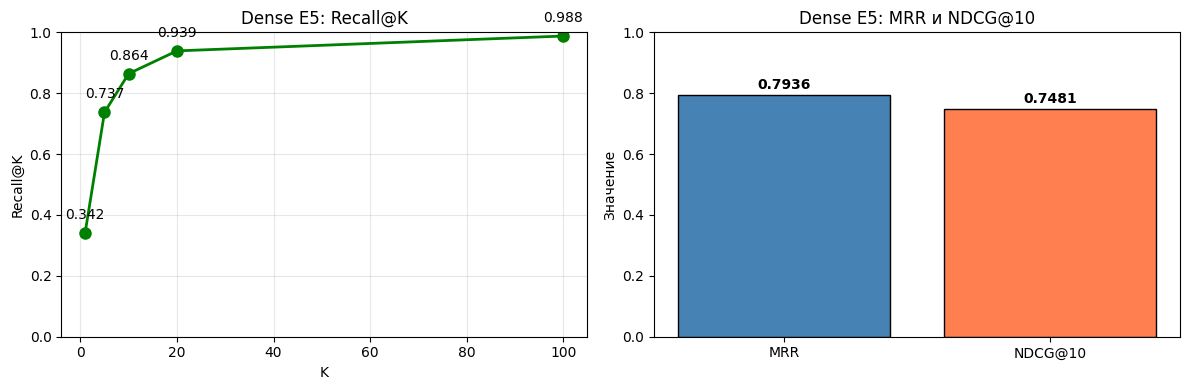

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Recall@K
ks = [1, 5, 10, 20, 100]
recalls = [dense_dev_metrics[f'Recall@{k}'] for k in ks]

axes[0].plot(ks, recalls, 'o-', linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Recall@K')
axes[0].set_title('Dense E5: Recall@K')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

for k, r in zip(ks, recalls):
    axes[0].annotate(f'{r:.3f}', (k, r), textcoords="offset points", xytext=(0, 10), ha='center')

# MRR и NDCG
metrics_names = ['MRR', 'NDCG@10']
values = [dense_dev_metrics['MRR'], dense_dev_metrics['NDCG@10']]

bars = axes[1].bar(metrics_names, values, color=['steelblue', 'coral'], edgecolor='black')
axes[1].set_ylabel('Значение')
axes[1].set_title('Dense E5: MRR и NDCG@10')
axes[1].set_ylim(0, 1)

for bar, val in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('dense_e5_results.png', dpi=150)
plt.show()

## 7. Сохранение результатов

In [12]:
results = {
    'model': MODEL_NAME,
    'corpus_size': len(corpus),
    'dimension': dense_retriever.dimension,
    'metrics': dense_dev_metrics
}

with open('dense_e5_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("Результаты сохранены: dense_e5_metrics.json")

Результаты сохранены: dense_e5_metrics.json


In [13]:
print(f"""
Итоги Dense Retriever:

Модель: {MODEL_NAME}
Размерность: {dense_retriever.dimension}
Документов: {len(corpus):,}

Результаты (dev):
  MRR:       {dense_dev_metrics['MRR']:.4f}
  Recall@10: {dense_dev_metrics['Recall@10']:.4f}
  NDCG@10:   {dense_dev_metrics['NDCG@10']:.4f}

Файлы:
  dense_e5.faiss - FAISS индекс
  dense_e5_metrics.json - метрики
""")


Итоги Dense Retriever:

Модель: intfloat/multilingual-e5-base
Размерность: 768
Документов: 541,007

Результаты (dev):
  MRR:       0.7936
  Recall@10: 0.8642
  NDCG@10:   0.7481

Файлы:
  dense_e5.faiss - FAISS индекс
  dense_e5_metrics.json - метрики

